# Classifier based on LLM-as-a-judge metrics

- **Goal:** detect hallucination using different LLM-as-a-judge metrics
- The aim of this notebook is to see whether the metric generated by the LLM-as-a-judge can be used in a supervised classification setting, to do so we have generated metrics using the prompts located in Production_Pipeline/prompts in order to use numerical values for the hallucination detection task.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch


## Dataset import
- We import both the ragtruth dataset as well as the backups of the metrics generated by the LLM-as-a-judge.


In [ ]:
ragtruth = pd.read_parquet("./dataset/ragtruth.parquet")
ragtruth = ragtruth[ragtruth["task_type"] == "QA"]

ragtruth["labels"] = ragtruth["labels"].apply(lambda x: False if len(x) == 0 else x)
ragtruth["labels"] = ragtruth["labels"].apply(lambda x: x[0]["label_type"] if type(x) != bool else x)

# Filter rows where labels are not False
positive_labels = ragtruth[ragtruth["labels"] != False]
llama = ragtruth[ragtruth["model"].str.contains("llama")]

def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks
chunks_l = split_dataframe(positive_labels, chunk_size=100)
chunks = split_dataframe(df, chunk_size=100)

In [ ]:
files = glob.glob("data_backup/backup*.parquet")
df = pd.concat([pd.read_parquet(f) for f in files])

df.drop(columns=["temperature"], inplace=True)
df.dropna(inplace=True)

X = df.drop(columns=["label"])
y = df["label"]
label_mapping = {label: idx for idx, label in enumerate(y.unique())}
y = y.map(label_mapping)

y = (y > 0).astype(int)

## First steps

In [ ]:
X_I, X_eval, y_I, y_eval = train_test_split(X, y, test_size=0.2, random_state=40)
X_train, X_calibr, y_train, y_calibr = train_test_split(X_I, y_I, test_size=0.25, random_state=40)

We built a simple MLP for the classification task:

In [ ]:
class BasicMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(BasicMLP, self).__init__()
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, 6),
            nn.ReLU(),
            nn.Linear(6, 4),
            nn.ReLU(),
            nn.Linear(4, output_size),
        )

    def forward(self, x):
        return self.ffnn(x)

In [ ]:
model = BasicMLP(X_train.shape[1], len(y.value_counts().index))
optimizer = optim.Adam(
    model.parameters(),
)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
x_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32, requires_grad=True)
y_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)

# Create a TensorDataset
dataset = TensorDataset(x_tensor, y_tensor)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

EPOCH 1:
2.096238076686859
EPOCH 6:
2.0491836071014404
EPOCH 11:
2.0133867263793945
EPOCH 16:
1.9977125525474548
EPOCH 21:
1.9758008122444153
EPOCH 26:
1.9765361547470093
EPOCH 31:
1.9664828181266785
EPOCH 36:
1.9606168866157532
EPOCH 41:
1.9519909024238586
EPOCH 46:
1.9449637532234192
EPOCH 51:
1.9356598258018494
EPOCH 56:
1.9270538687705994
EPOCH 61:
1.9113787412643433
EPOCH 66:
1.8993296027183533
EPOCH 71:
1.8871519565582275
EPOCH 76:
1.8823427557945251
EPOCH 81:
1.8530427813529968
EPOCH 86:
1.83912992477417
EPOCH 91:
1.8230759501457214
EPOCH 96:
1.7929975986480713
EPOCH 101:
1.7767256498336792
EPOCH 106:
1.7765145897865295
EPOCH 111:
1.7532448172569275
EPOCH 116:
1.7306362390518188
EPOCH 121:
1.744530975818634
EPOCH 126:
1.7212302088737488
EPOCH 131:
1.7262367010116577
EPOCH 136:
1.6946613788604736
EPOCH 141:
1.7065783739089966
EPOCH 146:
1.6935637593269348
EPOCH 151:
1.6953627467155457
EPOCH 156:
1.711883544921875
EPOCH 161:
1.6830564141273499
EPOCH 166:
1.6946403980255127
EPOCH 1

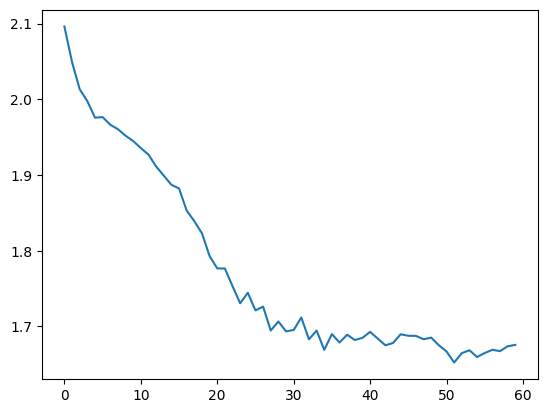

In [ ]:
EPOCHS = 300

losses = []
for epoch in range(EPOCHS):
    running_loss = 0.
    last_loss = 0.

    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 5 == 0:
        print('EPOCH {}:'.format(epoch + 1))
        losses.append(running_loss)
        print(running_loss)

plt.plot(losses)

We trained other model as well but few attempts were conclusive:

In [ ]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

log = LogisticRegression(penalty='l2')
knn = KNeighborsClassifier(n_neighbors=4)
lgbm = LGBMClassifier()

lgbm.fit(X_train, y_train)
knn.fit(X_train.values, y_train)

## Results plots

We look at usual plots to corroborate the validity of the model, notably:
- a ROC area plot
- a confusion matrix

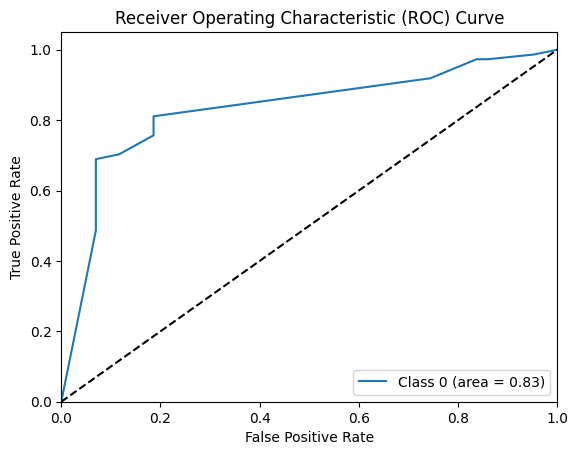

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

cm = confusion_matrix(y_eval, lgbm.predict(X_eval))
# Print classification report
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_eval))

for i in range(n_classes - 1):
    fpr[i], tpr[i], _ = roc_curve(y_eval == i, lgbm.predict_proba(X_eval)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(n_classes - 1):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

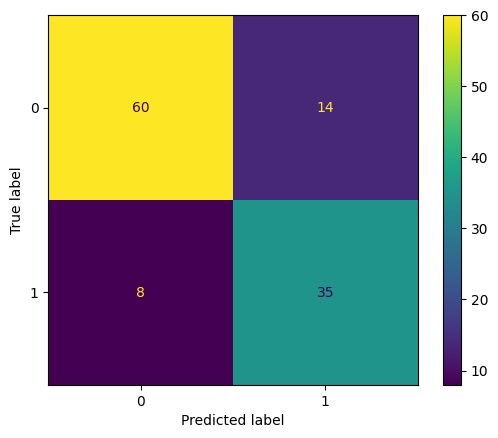

In [ ]:
ConfusionMatrixDisplay(cm).plot()

In [ ]:
X_tensor_calibr = torch.tensor(X_calibr.to_numpy(), dtype=torch.float32)
y_tensor_calibr = torch.tensor(y_calibr.to_numpy(), dtype=torch.long)
dataset = TensorDataset(X_tensor_calibr, y_tensor_calibr)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [ ]:
with torch.no_grad():
    running_vloss = 0.
    avg_loss = 0.
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    
        avg_vloss = running_vloss / (i + 1)

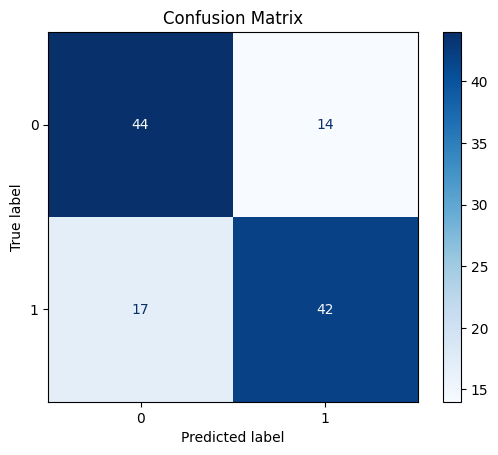

Pearson correlation coefficient: 0.4837085207486996
0.7350427350427351
              precision    recall  f1-score   support

           0       0.72      0.76      0.74        58
           1       0.75      0.71      0.73        59

    accuracy                           0.74       117
   macro avg       0.74      0.74      0.73       117
weighted avg       0.74      0.74      0.73       117

Pearson correlation coefficient for lgbm: 0.4837085207486996
Kendall's tau correlation: 0.3802365218895061
Kendall's tau correlation for lgbm: 0.3802365218895061


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau

true_labels = []
predicted_labels = []
probs = []
# Set model to evaluation mode
model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        # Get model outputs
        outputs = model(inputs)  # Raw logits
        
        # Apply sigmoid activation
        probabilities = F.softmax(outputs, dim=1)
        
        # Compute argmax for class prediction
        predictions = torch.argmax(probabilities, dim=1)
        
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        probs.extend(probabilities.cpu().numpy())

# Convert to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
probs = np.array(probs)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("dl.png")
plt.show()

# Compute Pearson correlation coefficient
pearson_corr, _ = pearsonr(true_labels, probs[:, 1])
print(f"Pearson correlation coefficient: {pearson_corr}")

print(accuracy_score(true_labels, predicted_labels))
# print(accuracy_score(true_labels, lgbm.predict(X_eval)))
print(classification_report(true_labels, predicted_labels))

# pearson_corr, _ = pearsonr(true_labels, lgbm.predict_proba(X_eval)[:, 1])
print(f"Pearson correlation coefficient for lgbm: {pearson_corr}")
# Compute Kendall's tau correlation
kendall_tau, _ = kendalltau(true_labels, probs[:, 1])
print(f"Kendall's tau correlation: {kendall_tau}")

# kendall_tau, _ = kendalltau(true_labels, lgbm.predict_proba(X_eval)[:, 1])
print(f"Kendall's tau correlation for lgbm: {kendall_tau}")

## Conformal predictions
Conformal prediction is a statistical framework that provides a measure of uncertainty for predictions, ensuring a specified level of confidence. Given a significance level $ \alpha $, conformal prediction constructs a prediction set $ \mathcal{C}(x) $ for a test sample $ x $ such that the true label $ y $ lies within $ \mathcal{C}(x) $ with a probability of at least $ 1 - \alpha $. Mathematically, this can be expressed as:

$$ P(y \in \mathcal{C}(x)) \geq 1 - \alpha $$


The method relies on conformity scores, which measure how well a sample conforms to the distribution of the training data. For a given sample $x_i$ with label $y_i$, the conformity score is computed as:

$$s_i = 1 - \hat{p}_{y_i}$$


where $ \hat{p}_{y_i} $ is the predicted probability for the true label $y_i$. The $(1-\alpha)$-quantile of the conformity scores from a calibration set determines the threshold $ q $. For a test sample $ x $, the prediction set $\mathcal{C}(x)$ includes all labels $y$ satisfying:

$$
1 - \hat{p}_y \leq q
$$

This approach ensures that the prediction set adapts to the uncertainty of the model, providing a principled way to balance precision and recall.

In [ ]:
import numpy as np

# Define the function for conformal prediction
def conformal_prediction(calibrated_probs, labels, alpha=0.05):
    """
    Perform conformal prediction with calibrated probabilities.

    Args:
        calibrated_probs (np.ndarray): Calibrated probabilities for the hold-out set (I2).
        labels (np.ndarray): Ground truth labels for the hold-out set (I2).
        test_probs (np.ndarray): Probabilities for the test sample.
        alpha (float): Risk tolerance level.

    Returns:
        prediction_set (list): Labels included in the prediction set for the test sample.
        quantile (float): The (1-alpha)-quantile of the conformity scores.
    """
    # Compute conformity scores for the hold-out set
    conformity_scores = 1 - np.array([probs[label] for probs, label in zip(calibrated_probs, labels)])

    # Compute the (1-alpha) quantile of the conformity score distribution
    # Include the adjustment \delta_\infty
    num_samples = len(conformity_scores)
    extended_scores = np.append(conformity_scores, float('inf'))
    quantile = np.sort(extended_scores)[int((1 - alpha) * (num_samples + 1)) - 1]

    return quantile

In [ ]:
X_tensor_eval = torch.tensor(X_eval.to_numpy(), dtype=torch.float32)
y_tensor_eval = torch.tensor(y_eval.to_numpy(), dtype=torch.long)
dataset = TensorDataset(X_tensor_eval, y_tensor_eval)
true_test_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

0.7360870838165283


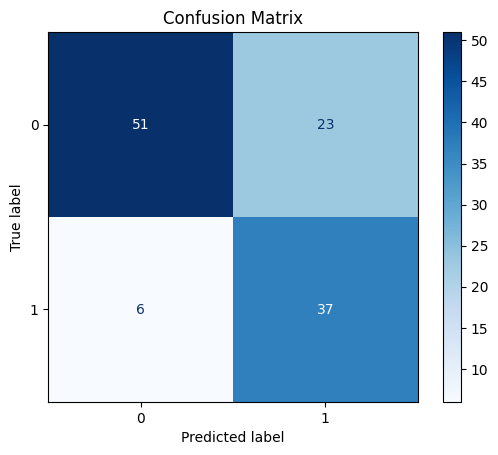

Pearson correlation coefficient: 0.5728827499016765
0.7521367521367521
              precision    recall  f1-score   support

           0       0.89      0.69      0.78        74
           1       0.62      0.86      0.72        43

    accuracy                           0.75       117
   macro avg       0.76      0.77      0.75       117
weighted avg       0.79      0.75      0.76       117



In [ ]:
eval_true_labels = []
eval_predicted_labels = []
eval_probs = []
# Set model to evaluation mode
import torch.nn.functional as F
model.eval()


q = conformal_prediction(probs, true_labels, alpha=0.1)
print(q)
with torch.no_grad():
    for inputs, labels in true_test_loader:
        # Get model outputs
        outputs = model(inputs)  # Raw logits
        
        # Apply sigmoid activation
        probabilities = F.softmax(outputs, dim=1)
        
        
        # Compute argmax for class prediction, we can decomment the next line to use the q value
        # this allows a tradeoff between precision and recall with more explainability
        predictions = torch.argmax(probabilities, dim=1)
        # predictions = probabilities[:, 1] >= 1 - q
        
        # Store true and predicted labels
        eval_true_labels.extend(labels.cpu().numpy())
        eval_predicted_labels.extend(predictions.cpu().numpy())
        eval_probs.extend(probabilities.cpu().numpy())

eval_true_labels = np.array(eval_true_labels)
eval_predicted_labels = np.array(eval_predicted_labels)
eval_probs = np.array(eval_probs)

cm = confusion_matrix(eval_true_labels, eval_predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("dl.png")
plt.show()

# Compute Pearson correlation coefficient
pearson_corr, _ = pearsonr(eval_true_labels, eval_probs[:, 1])
print(f"Pearson correlation coefficient: {pearson_corr}")

print(accuracy_score(eval_true_labels, eval_predicted_labels))
print(classification_report(eval_true_labels, eval_predicted_labels))


- Using the conformal prediction, we can see that the Type I error varies given the conformal threshold we have chosen, this is expected as the threshold will dictate how many instances will be labelled as hallucinated and vice-versa.

- The approach is not the most useful in our context as it is difficult to use this method proficiently.